# Breast Cancer

Goals: Analyse breast cancer medical data ("Breast Cancer Wisconsin (Diagnostic) Data Set") and create a model to predict diagnosis (benign or malignant tumor).

Methods:
 - Check and visualize feature correlations
 - Use Adaboost and XGBoost on the ‘Breast Cancer’ dataset to predict a diagnosis
 - Find most important features
 - Further tune hyperparameters with random and grid search
 
The dataset and more descriptions can be found here: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

## The dataset

Attribute information

ID number
Diagnosis (M = malignant, B = benign)
Ten real-valued features are computed for each cell nucleus:
- radius (mean of distances from center to points on the perimeter)
- texture (standard deviation of gray-scale values)
- perimeter
- area
- smoothness (local variation in radius lengths)
- compactness (perimeter^2 / area - 1.0)
- concavity (severity of concave portions of the contour)
- concave points (number of concave portions of the contour)
- symmetry
- fractal dimension (“coastline approximation” - 1)

## Libraries

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.model_selection import RandomizedSearchCV # for random search
from sklearn.model_selection import GridSearchCV # for grid search

# models
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.metrics import classification_report

from sklearn.model_selection import cross_val_score
import seaborn as sns
import pprint # for nicer printing
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler # to scale the features

## Data exploration and preparation 

In [0]:
bc_data = pd.read_csv('data-breast-cancer.csv', delimiter=",")

In [0]:
bc_data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [0]:
bc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
id                         569 non-null int64
diagnosis                  569 non-null object
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non

- id is not useful (identifies case only)
- The target is "diagnosis" (object type)
- The features are everything else (float) --> no onehot encoding needed

In [0]:
# drop Unnamed: 32 column that is empty
bc_data=bc_data.drop(columns=["Unnamed: 32"])

In [0]:
# drop id as it holds no relevant information
bc_data=bc_data.drop(columns=["id"])

In [0]:
bc_data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Investigate features and target

In [0]:
# how balanced is it?
# B: benign, M: malignant

bc_data["diagnosis"].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

It's somewhat unbalanced. There are (luckily) more benign than malignant tumors

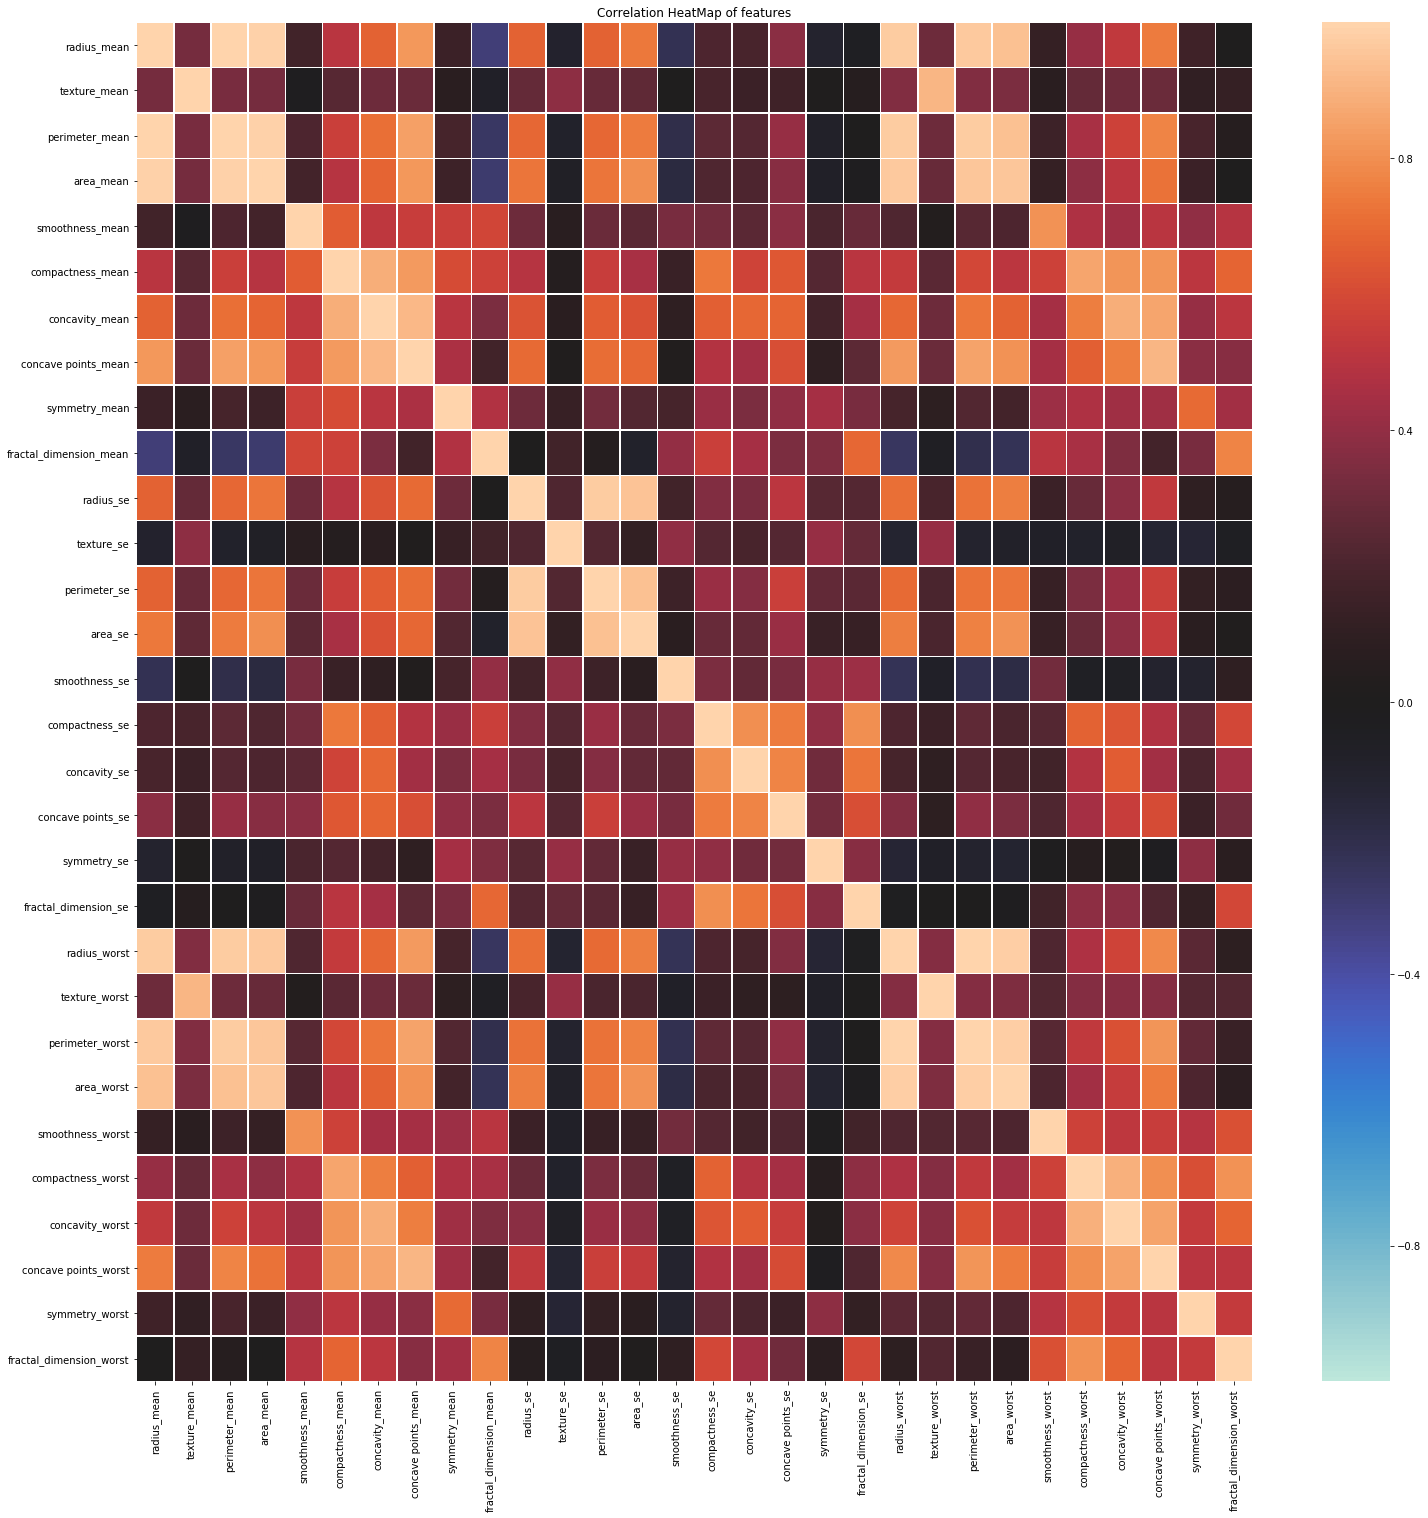

In [0]:
# creating pairwise correlation of columns using Pearson's test
corr = bc_data.loc[:, bc_data.columns != 'diagnosis'].corr(method='pearson')

# plotting the correlation coefficients on a seasborn heatmap matrix
fig, ax = plt.subplots(figsize=(25, 25))
sns.heatmap(corr, annot=False, xticklabels=corr.columns,
            yticklabels=corr.columns, ax=ax, linewidths=.5,
            vmin=-1, vmax=1, center=0)

plt.title('Correlation HeatMap of features')
plt.show()

Many features are highly positively correlated as they basically build on each other.

E.g. radius/perimeter/area, and mean/worst in many cases

## First model: random forest with all features

In [0]:
# split into X and y

X_all = bc_data.drop(columns=["diagnosis"])

y_raw_all = bc_data["diagnosis"]
y_all = pd.DataFrame({"Outcome": y_raw_all})  # Outcome is the new column title

# I replace M and B with 1/0, respectively, although tis is not strictly necessary
y_all[y_all == "B"] = 0.0  # benign: non-event
y_all[y_all == "M"] = 1.0  # malignant: event

# y is currently of object type
# cast y as int

y_all = y_all.astype("int")
y_all.info()

# test/train split
# these are the final sets as no conversion(encoding) is needed; all are digits (int and float)
# no scaling is needed in random forests

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all,
                                                                    y_all,
                                                                    test_size=.30,
                                                                    random_state=0)

clf_all = RandomForestClassifier(bootstrap=True, class_weight="balanced_subsample", criterion='gini',
                                 max_depth=4, min_samples_split=10, n_estimators=100, n_jobs=5, oob_score=False, random_state=None, warm_start=False).fit(X_train_all, y_train_all.Outcome)

clf_all.score(X_train_all, y_train_all.Outcome)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 1 columns):
Outcome    569 non-null int64
dtypes: int64(1)
memory usage: 4.5 KB


0.9849246231155779

In [0]:
X_all.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [0]:
# now we should investiate thefeature importances in this (already quite good) model

importances_all = pd.DataFrame(clf_all.feature_importances_)

importances_all.columns = ['importance'] # rename column

importances_all["feature"] = X_train_all.columns # add features as second column

importances_all = importances_all[["feature", 'importance']]

importances_all.sort_values(by='importance', ascending=False)

,feature,importance
22,perimeter_worst,0.156653
23,area_worst,0.129298
27,concave points_worst,0.125329
7,concave points_mean,0.123755
6,concavity_mean,0.073424
20,radius_worst,0.070176
26,concavity_worst,0.048437
13,area_se,0.041720
0,radius_mean,0.031082
2,perimeter_mean,0.031049


It appears that there are several features that contribute similarly, but no single one that decides the outcome.

## List highly correlated features

In [0]:
# loop to get the columns with highly correlated features

correlated_features = set()
for i in range(len(corr.columns)):
    for j in range(i):
        # this number could be lower or higher, depending on the data and number of features
        if abs(corr.iloc[i, j]) > 0.85:
            colname = corr.columns[i]
            correlated_features.add(colname)
correlated_features

{'area_mean',
 'area_se',
 'area_worst',
 'compactness_worst',
 'concave points_mean',
 'concave points_worst',
 'concavity_mean',
 'concavity_worst',
 'perimeter_mean',
 'perimeter_se',
 'perimeter_worst',
 'radius_worst',
 'texture_worst'}

## X, y split (of whole dataset)

In [0]:
# split into X and y

X = bc_data.drop(columns=["diagnosis"])

y_raw = bc_data["diagnosis"]
y = pd.DataFrame({"Outcome": y_raw})  # Outcome is the new column title

y[y == "B"] = 0.0  # benign: non-event
y[y == "M"] = 1.0  # malignant: event

# y is currently of object type

In [0]:
X.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [0]:
# cast y as int

y=y.astype("int")
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 1 columns):
Outcome    569 non-null int64
dtypes: int64(1)
memory usage: 4.5 KB


In [0]:
# scale features (X)

scaler = StandardScaler()
X_sc=scaler.fit_transform(X)
X_sc=pd.DataFrame(data=X_sc, columns=X.columns)

In [0]:
X_sc.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,2.489734,-0.565265,2.833031,2.487578,-0.214002,1.316862,0.724026,0.660820,1.148757,0.907083,1.886690,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,0.499255,-0.876244,0.263327,0.742402,-0.605351,-0.692926,-0.440780,0.260162,-0.805450,-0.099444,1.805927,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190
2,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,1.228676,-0.780083,0.850928,1.181336,-0.297005,0.814974,0.213076,1.424827,0.237036,0.293559,1.511870,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391
3,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,0.326373,-0.110409,0.286593,-0.288378,0.689702,2.744280,0.819518,1.115007,4.732680,2.047511,-0.281464,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010
4,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,1.270543,-0.790244,1.273189,1.190357,1.483067,-0.048520,0.828471,1.144205,-0.361092,0.499328,1.298575,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100


## PCA for the features

Here, the number of features is quite small, so a principle component analysis (PCA) is optional. If it is not performed, the highly correlated features (listed above) should be removed as not to skew the results

In [0]:
# I aim to explain the variance to about 90%, but lower numbers may also be accempatble.
n_components = 7

pca = PCA(n_components=7)

principalComponents = pca.fit_transform(X_sc)

principalDf = pd.DataFrame(data=principalComponents, columns=[
                           'PC1', 'PC2', 'PC3', 'PC4', "PC5", "PC6", "PC7"])

In [0]:
print(principalDf.head())
print(pca.explained_variance_ratio_)
print("The 7 principal components explain " + str(sum(pca.explained_variance_ratio_)*100) + "% of the variance.")

        PC1        PC2       PC3       PC4       PC5       PC6       PC7
0  9.192837   1.948583 -1.123166  3.633731 -1.195111  1.411424  2.159367
1  2.387802  -3.768172 -0.529293  1.118264  0.621775  0.028657  0.013356
2  5.733896  -1.075174 -0.551748  0.912083 -0.177086  0.541452 -0.668167
3  7.122953  10.275589 -3.232790  0.152547 -2.960878  3.053422  1.429917
4  3.935302  -1.948072  1.389767  2.940639  0.546747 -1.226495 -0.936207
[0.44272026 0.18971182 0.09393163 0.06602135 0.05495768 0.04024522
 0.02250734]
The 7 principal components explain 91.00953006962857% of the variance.


In [0]:
principalDf.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,9.192837,1.948583,-1.123166,3.633731,-1.195111,1.411424,2.159367
1,2.387802,-3.768172,-0.529293,1.118264,0.621775,0.028657,0.013356
2,5.733896,-1.075174,-0.551748,0.912083,-0.177086,0.541452,-0.668167
3,7.122953,10.275589,-3.232790,0.152547,-2.960878,3.053422,1.429917
4,3.935302,-1.948072,1.389767,2.940639,0.546747,-1.226495,-0.936207


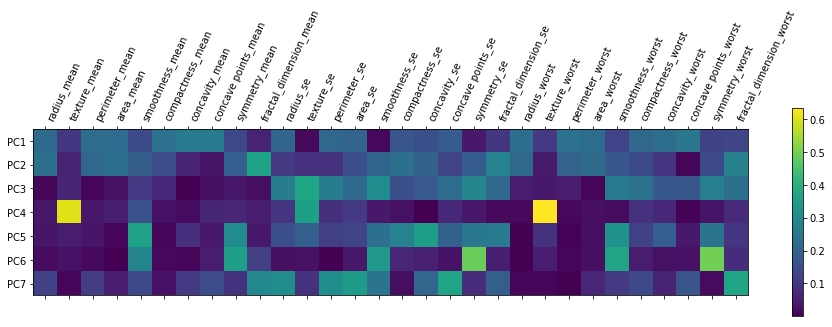

In [0]:
plt.matshow(abs(pca.components_), cmap='viridis')
plt.yticks([0, 1, 2, 3, 4, 5, 6], ['PC1', 'PC2', 'PC3',
                                   'PC4', "PC5", "PC6", "PC7"], fontsize=10)
plt.colorbar()
plt.xticks(range(len(X_sc.columns)), X_sc.columns, rotation=65, ha='left')
plt.show()

From this figure, we see which features are most prominent in the principle components and carry most weight.

### Test-val-train split

In [0]:
# test/train split; typical ratios are between 70/30 and 80/20
# these are the final sets as no conversion (encoding) is needed; all are digits
# no scaling is needed in random forests

X_train, X_test, y_train, y_test = train_test_split(principalDf,
                                                    y,
                                                    test_size=.30,
                                                    random_state=0)

# the train-set is further divided into train and val
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=.30,
                                                  random_state=0)

In [0]:
X_train.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
149,-3.049925,-2.237785,-0.469453,0.182775,1.575846,0.408800,0.489983
442,-3.454718,-2.136462,0.197163,1.534177,0.942875,-0.937122,0.683260
365,2.735012,-3.945168,-0.017170,0.300111,0.283266,-0.577315,-0.663537
474,-1.990529,1.899463,-2.030998,0.911906,1.231554,-0.419626,1.287905
19,-1.237063,-0.188215,-0.593284,1.596346,-0.442155,-0.048635,-1.201677


In [0]:
y_train.head()

,Outcome
149,0
442,0
365,1
474,0
19,0


## Random Forest classifier

In [0]:
# the random forest needs to have "balanced_subsample" to account for the uneven y values
clf_rf = RandomForestClassifier(bootstrap=True, class_weight="balanced_subsample", criterion='gini',
                                max_depth=15, min_samples_split=10, n_estimators=1500, n_jobs=5, oob_score=False,
                                random_state=42, warm_start=False).fit(X_train, y_train.Outcome)

clf_rf_scores = cross_val_score(clf_rf, X_train, y_train.Outcome, cv=5)
print("5-fold cross validation score: " + str(clf_rf_scores.mean()))

5-fold cross validation score: 0.953177261335156


As you can see, this is already quite high. Let's look at the feature importances.

In [0]:
clf_rf.score(X_train, y_train.Outcome)

importances_clf_rf = pd.DataFrame(clf_rf.feature_importances_)

importances_clf_rf.columns = ['importance'] # rename column

importances_clf_rf["feature"] = X_train.columns# add features as second column

importances_clf_rf = importances_clf_rf[["feature", 'importance']]

importances_clf_rf.sort_values(by='importance', ascending=False)

,feature,importance
0,PC1,0.634978
2,PC3,0.101289
1,PC2,0.099465
4,PC5,0.051587
3,PC4,0.040528
6,PC7,0.039625
5,PC6,0.032529


PC1 contibutes most weight to the classification and PC6 and 7 carry the lowest.

### Random and grid search

The results already look fine, but by performing random and grid search, the hyperparameters in the classifier can be further tuned.

#### Random search

In [0]:
rf = RandomForestClassifier(class_weight="balanced_subsample")

param_grid_random = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': [1000, 1500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [5, 6, 7, 8, 9, 10],
    'min_samples_leaf': [1, 2, 3, 4],
    'min_samples_split': [2, 4, 6, 8, 10]
}

In [0]:
rf_rs = RandomizedSearchCV(rf, param_grid_random,
                           n_iter=100, cv=5, scoring='roc_auc', n_jobs=-1)
rf_rs.fit(X_train, y_train.Outcome)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight='balanced_subsample',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                               

In [0]:
# Checking for best parameters
rf_rs.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 1000}

In [0]:
# Best Model RandomSearch
# Applying best model
rf_rs.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
                       criterion='gini', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [0]:
# Evaluate RandomSearch model
scores_rs = cross_val_score(rf_rs.best_estimator_,
                            X_train, y_train.Outcome, cv=5, scoring='roc_auc')
scores_rs.mean()

0.9905347593582888

#### Grid search

In [0]:
# setup grid with results similar to random search outcomes

param_grid = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': [900, 1000, 1100],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [9, 10, 11],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4]
}

In [0]:
# Build Grid Search model
rfc_gs = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
rfc_gs.fit(X_train, y_train.Outcome)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced_subsample',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=N...
                                              oob_score=False,
                                              random_state=None, verbose=0,
                    

In [0]:
# Checking for best parameters
rfc_gs.best_params_

{'criterion': 'gini',
 'max_depth': 9,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1000}

In [0]:
# Best Model GridSearch
# Applying best model
rfc_gs.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
                       criterion='gini', max_depth=9, max_features='log2',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [0]:
# Evaluate GridSearch model
scores_gs = cross_val_score(rfc_gs.best_estimator_,
                            X_train, y_train.Outcome, cv=5, scoring='roc_auc')
scores_gs.mean()

0.9918716577540106

### Optimized Random Forest classifier

In [0]:
clf_rf_best = rfc_gs.best_estimator_.fit(X_train, y_train.Outcome)

clf_rf_best_scores = cross_val_score(
    clf_rf_best, X_train, y_train.Outcome, cv=5)
print("5-fold cross validation score: " + str(clf_rf_best_scores.mean()))

5-fold cross validation score: 0.9677227158806107


### Validation

In [0]:
# show how it performs on validation data
predictions_clf_rf = clf_rf_best.predict(X_val)

# build a confusion matrix by hand
confusion_rf_best = pd.DataFrame(confusion_matrix(y_val, predictions_clf_rf))

Precision = confusion_rf_best.loc[1, 1] /(confusion_rf_best.loc[1, 1]+confusion_rf_best.loc[1, 0])*100

ER = (confusion_rf_best.loc[1, 0]+confusion_rf_best.loc[0, 1])/(confusion_rf_best.loc[1, 1] +
                                                                confusion_rf_best.loc[1, 0]+confusion_rf_best.loc[0, 1]+confusion_rf_best.loc[0, 0])*100

Accuracy = (confusion_rf_best.loc[1, 1]+confusion_rf_best.loc[0, 0])/(confusion_rf_best.loc[1, 1] +
                                                                      confusion_rf_best.loc[1, 0]+confusion_rf_best.loc[0, 1]+confusion_rf_best.loc[0, 0])*100

# Put numbers on these results
print("Accuracy ((TP+TN)/all): " + str(round(Accuracy, 2)) + "%")

print("Precision (TP/(TP+FN)): " + str(round(Precision, 2)) + "%")

print("Error Rate ((FP+FN)/all): " + str(round(ER, 2)) + "%")

confusion_rf_best

Accuracy ((TP+TN)/all): 95.83%
Precision (TP/(TP+FN)): 95.24%
Error Rate ((FP+FN)/all): 4.17%


,0,1
0,75,3
1,2,40


In [0]:
# get the metrics for the classifications

print(classification_report(y_val, predictions_clf_rf))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97        78
           1       0.93      0.95      0.94        42

    accuracy                           0.96       120
   macro avg       0.95      0.96      0.95       120
weighted avg       0.96      0.96      0.96       120



## AdaClassifier

In [0]:
# Fit a AdaBoost model, compare it to clf_rf

ada_clf = AdaBoostClassifier(n_estimators=1500,
                             learning_rate=0.8,
                             random_state=42)

ada_clf.fit(X_train, y_train.Outcome)

ada_clf_scores = cross_val_score(ada_clf, X_train, y_train.Outcome, cv=5)
print("5-fold cross validation score: " + str(ada_clf_scores.mean()))

importances_ada = pd.DataFrame(ada_clf.feature_importances_)

importances_ada.columns = ['importance']  # rename column

importances_ada["feature"] = X_train.columns  # add features as second column

importances_ada = importances_ada[["feature", 'importance']]

importances_ada.sort_values(by='importance', ascending=False)

5-fold cross validation score: 0.9495431761221234


,feature,importance
0,PC1,0.236000
1,PC2,0.162000
3,PC4,0.148000
2,PC3,0.140667
4,PC5,0.130000
6,PC7,0.102000
5,PC6,0.081333


### Random and grid search

#### Random search

In [0]:
ada = AdaBoostClassifier()

param_grid_random = {
    'n_estimators': [50, 100, 150, 200, 500],
    'learning_rate': [0.1, 0.5, 1, 1.5]}

In [0]:
ada_rs = RandomizedSearchCV(ada, param_grid_random,
                             cv=5, scoring='roc_auc', n_jobs=-1)
ada_rs.fit(X_train, y_train.Outcome)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                                base_estimator=None,
                                                learning_rate=1.0,
                                                n_estimators=50,
                                                random_state=None),
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.5, 1, 1.5],
                                        'n_estimators': [50, 100, 150, 200,
                                                         500]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='roc_auc', verbose=0)

In [0]:
# Checking for best parameters
ada_rs.best_params_

{'learning_rate': 1, 'n_estimators': 100}

In [0]:
# Best Model RandomSearch
# Applying best model
ada_rs.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_estimators=100, random_state=None)

In [0]:
# Evaluate RandomSearch model
scores_ada_rs = cross_val_score(
    ada_rs.best_estimator_, X_train, y_train.Outcome, cv=5, scoring='roc_auc')
scores_ada_rs.mean()

0.9889661319073084

#### Grid search

In [0]:
# setup grid with results similar to random search outcomes

param_grid = {
    'n_estimators': [70, 80, 90, 100, 110, 120],
    'learning_rate': [0.8, 1, 1.2]
}

In [0]:
# Build Grid Search model
ada_gs = GridSearchCV(ada, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
ada_gs.fit(X_train, y_train.Outcome)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=None),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.8, 1, 1.2],
                         'n_estimators': [70, 80, 90, 100, 110, 120]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [0]:
# Checking for best parameters
ada_gs.best_params_

{'learning_rate': 1, 'n_estimators': 90}

In [0]:
# Best Model GridSearch
# Applying best model
ada_gs.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_estimators=90, random_state=None)

In [0]:
# Evaluate GridSearch model
scores_ada_gs = cross_val_score(ada_gs.best_estimator_,
                                X_train, y_train.Outcome, cv=5, scoring='roc_auc')
scores_ada_gs.mean()

0.9900331041507513

### Optimized AdaClassifier

In [0]:
clf_ada_best = ada_gs.best_estimator_.fit(X_train, y_train.Outcome).fit(X_train, y_train.Outcome)

clf_ada_best_scores = cross_val_score(
    clf_ada_best, X_train, y_train.Outcome, cv=5)
print("5-fold cross validation score: " + str(clf_ada_best_scores.mean()))

5-fold cross validation score: 0.9640236956026429


### Validation

In [0]:
predictions_ada = clf_ada_best.predict(X_val)

accuracy = accuracy_score(y_val.Outcome, predictions_ada)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

confusion_ada_best = pd.DataFrame(
    confusion_matrix(y_val.Outcome, predictions_ada))

Precision = confusion_ada_best.loc[1, 1] /(confusion_ada_best.loc[1, 1]+confusion_ada_best.loc[1, 0])*100

ER = (confusion_ada_best.loc[1, 0]+confusion_ada_best.loc[0, 1])/(confusion_ada_best.loc[1, 1] +
                                                                  confusion_ada_best.loc[1, 0]+confusion_ada_best.loc[0, 1]+confusion_ada_best.loc[0, 0])*100

Accuracy = (confusion_ada_best.loc[1, 1]+confusion_ada_best.loc[0, 0])/(confusion_ada_best.loc[1, 1] +
                                                                        confusion_ada_best.loc[1, 0]+confusion_ada_best.loc[0, 1]+confusion_ada_best.loc[0, 0])*100

print("Accuracy ((TP+TN)/all): " + str(round(Accuracy, 2)) + "%")

print("Precision (TP/(TP+FN)): " + str(round(Precision, 2)) + "%")

print("Error Rate ((FP+FN)/all): " + str(round(ER, 2)) + "%")

confusion_ada_best

Accuracy: 96.67%
Accuracy ((TP+TN)/all): 96.67%
Precision (TP/(TP+FN)): 95.24%
Error Rate ((FP+FN)/all): 3.33%


,0,1
0,76,2
1,2,40


In [0]:
# get the metrics for the classifications
print(classification_report(y_val, predictions_ada))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        78
           1       0.95      0.95      0.95        42

    accuracy                           0.97       120
   macro avg       0.96      0.96      0.96       120
weighted avg       0.97      0.97      0.97       120



Lookin' good! Comparable to the random forest above.

## XGBoost

In [0]:
xgb_clf = XGBClassifier(max_depth=5, n_estimators=1500,
                        learning_rate=0.8, random_state=42)
xgb_clf.fit(X_train, y_train.Outcome)

xgb_clf_scores = cross_val_score(xgb_clf, X_train, y_train.Outcome, cv=5)
print("5-fold cross validation score: " + str(xgb_clf_scores.mean()))

importances_xgb = pd.DataFrame(xgb_clf.feature_importances_)

importances_xgb.columns = ['importance']  # rename column

importances_xgb["feature"] = X_train.columns  # add features as second column

importances_xgb = importances_xgb[["feature", 'importance']]

importances_xgb.sort_values(by='importance', ascending=False)

5-fold cross validation score: 0.9603873319662795


,feature,importance
0,PC1,0.839780
3,PC4,0.069788
4,PC5,0.037124
6,PC7,0.035897
1,PC2,0.006910
2,PC3,0.005314
5,PC6,0.005187


### Random search and grid search

#### Random rearch

In [0]:
xgb = XGBClassifier()

param_grid_random = {
    'learning_rate': [0.3, 0.5, 0.7, 1],
    'max_depth': [6, 8, 10, 12, 14],
    "lambda": [0, 0.5, 1],
    "alpha": [0, 0.5, 1]}

In [0]:
xgb_rs = RandomizedSearchCV(xgb, param_grid_random,
                            n_iter=100, cv=5, scoring='roc_auc', n_jobs=-1)
xgb_rs.fit(X_train, y_train.Outcome)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
          

In [0]:
# Checking for best parameters
xgb_rs.best_params_

{'alpha': 0.5, 'lambda': 1, 'learning_rate': 0.7, 'max_depth': 6}

In [0]:
# Best Model RandomSearch
# Applying best model
xgb_rs.best_estimator_

XGBClassifier(alpha=0.5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, lambda=1,
              learning_rate=0.7, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
# Evaluate RandomSearch model
scores_xgb_rs = cross_val_score(
    xgb_rs.best_estimator_, X_train, y_train.Outcome, cv=5, scoring='roc_auc')
scores_xgb_rs.mean()

0.9883320600967661

#### Grid search

In [0]:
param_grid = {
    'learning_rate': [0.1, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'max_depth': [4, 5, 6, 7, 8, 9, 10],
    "lambda": [0, 0.2, 0.5, 1, 1.2, 1.5],
    "alpha": [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1]}

In [0]:
# Build Grid Search model
xgb_gs = GridSearchCV(xgb, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
xgb_gs.fit(X_train, y_train.Outcome)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1],
                         'lambda': [0, 0.2, 0.5, 1, 1.2, 1.5],
                         'learning_ra

In [0]:
# Checking for best parameters
xgb_gs.best_params_

{'alpha': 0.3, 'lambda': 0, 'learning_rate': 0.7, 'max_depth': 5}

In [0]:
# Best Model GridSearch
# Applying best model
xgb_gs.best_estimator_

XGBClassifier(alpha=0.3, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, lambda=0,
              learning_rate=0.7, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
# Evaluate GridSearch model
scores_xgb_gs = cross_val_score(xgb_gs.best_estimator_,
                                X_train, y_train.Outcome, cv=5, scoring='roc_auc')
scores_xgb_gs.mean()

0.9883320600967661

### Optimized XGBoost

In [0]:
clf_xgb_best = xgb_gs.best_estimator_.fit(X_train, y_train.Outcome)

clf_xgb_best_scores = cross_val_score(
    clf_xgb_best, X_train, y_train.Outcome, cv=5)
print("5-fold cross validation score: " + str(clf_xgb_best_scores.mean()))

5-fold cross validation score: 0.9712314878104351


### Validation

In [0]:
predictions_gxb = clf_xgb_best.predict(X_val)

# evaluate predictions
confusion_gxb = pd.DataFrame(confusion_matrix(y_val.Outcome, predictions_gxb))


Precision = confusion_gxb.loc[1, 1]/(confusion_gxb.loc[1, 1]+confusion_gxb.loc[1, 0])*100

ER = (confusion_gxb.loc[1, 0]+confusion_gxb.loc[0, 1])/(confusion_gxb.loc[1, 1] +
                                                        confusion_gxb.loc[1, 0]+confusion_gxb.loc[0, 1]+confusion_gxb.loc[0, 0])*100

Accuracy = (confusion_gxb.loc[1, 1]+confusion_gxb.loc[0, 0])/(confusion_gxb.loc[1, 1] +
                                                              confusion_gxb.loc[1, 0]+confusion_gxb.loc[0, 1]+confusion_gxb.loc[0, 0])*100

print("Accuracy ((TP+TN)/all): " + str(round(Accuracy, 2)) + "%")

print("Precision (TP/(TP+FN)): " + str(round(Precision, 2)) + "%")

print("Error Rate ((FP+FN)/all): " + str(round(ER, 2)) + "%")

confusion_gxb

Accuracy ((TP+TN)/all): 95.83%
Precision (TP/(TP+FN)): 95.24%
Error Rate ((FP+FN)/all): 4.17%


,0,1
0,75,3
1,2,40


In [0]:
# get the metrics for the classifications
print(classification_report(y_val, predictions_gxb))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97        78
           1       0.93      0.95      0.94        42

    accuracy                           0.96       120
   macro avg       0.95      0.96      0.95       120
weighted avg       0.96      0.96      0.96       120



## Predicting the diagnosis on the test set with AdaBoost

In [0]:
predictions_ada = clf_ada_best.predict(X_test)

# evaluate predictions
confusion_ada = pd.DataFrame(confusion_matrix(y_test.Outcome, predictions_ada))


Precision = confusion_ada.loc[1, 1]/(confusion_ada.loc[1, 1]+confusion_ada.loc[1, 0])*100

ER = (confusion_ada.loc[1, 0]+confusion_ada.loc[0, 1])/(confusion_ada.loc[1, 1] +
                                                        confusion_ada.loc[1, 0]+confusion_ada.loc[0, 1]+confusion_ada.loc[0, 0])*100

Accuracy = (confusion_ada.loc[1, 1]+confusion_ada.loc[0, 0])/(confusion_ada.loc[1, 1] +
                                                              confusion_ada.loc[1, 0]+confusion_ada.loc[0, 1]+confusion_ada.loc[0, 0])*100

print("Accuracy ((TP+TN)/all): " + str(round(Accuracy, 2)) + "%")

print("Precision (TP/(TP+FN)): " + str(round(Precision, 2)) + "%")

print("Error Rate ((FP+FN)/all): " + str(round(ER, 2)) + "%")

confusion_ada

Accuracy ((TP+TN)/all): 94.74%
Precision (TP/(TP+FN)): 93.65%
Error Rate ((FP+FN)/all): 5.26%


,0,1
0,103,5
1,4,59


In [0]:
# get the metrics for the classifications
print(classification_report(y_test, predictions_ada))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       108
           1       0.92      0.94      0.93        63

    accuracy                           0.95       171
   macro avg       0.94      0.95      0.94       171
weighted avg       0.95      0.95      0.95       171



So, overall, the diagnosis can be predicted and the training and validation outcomes of all used models are pretty good.
The "best" model resulted in adequate predictions on the test data, but it could clearly be improved. 
Overfitting to the train and validation data may be an issue, as this data set is not particularly large.